# Monte Carlo Simulation - Portfolio Optimization

Let's start investing! Should I invest in a portfolio of companies or S&P500 ?
Steps:
- 1) Find the best stocks to buy from the U.S. market
- 2) Compare those selected companies to stock indices, and filter companies with high return rate  
- 3) Check correlation of returns to mitigate volatility and risk
- 4) Estimate Sharpe Ratio & CAPM
- 5) Randomly assign weights to our stocks in the 10,000 portfolios, then calculate the means of daily returns and volatilities of the returns
- 6) We select the portfolio with the highest Sharpe ratio rate to invest

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
tickers = ['AAPL','BP','PG','SEB','NVR','AMZN','F']
securities = pd.DataFrame()
def securities_data(tickers_list, df):
    for i in tickers_list:
        df[i] = wb.DataReader(i, data_source='yahoo', start='2014-1-1')['Adj Close']
    return df

In [3]:
securities = securities_data(tickers, securities)
securities.head()

,AAPL,BP,PG,SEB,NVR,AMZN,F
Date,,,,,,,
2014-01-02,70.747330,31.725683,65.854416,2743.711670,1017.099976,397.970001,11.368886
2014-01-03,69.193306,31.652954,65.780823,2752.552734,1019.349976,396.440002,11.420427
2014-01-06,69.570625,31.738913,65.936180,2682.025146,1025.630005,393.630005,11.471969
2014-01-07,69.073074,32.102577,66.573967,2728.702637,1013.880005,398.029999,11.324705
2014-01-08,69.510536,32.221600,65.609123,2682.025146,1009.900024,401.920013,11.442515


In [4]:
# some companies' data are not provided by Yahoo
securities.dropna(axis=1, inplace=True) 

### Normalize data and Compare the return rate

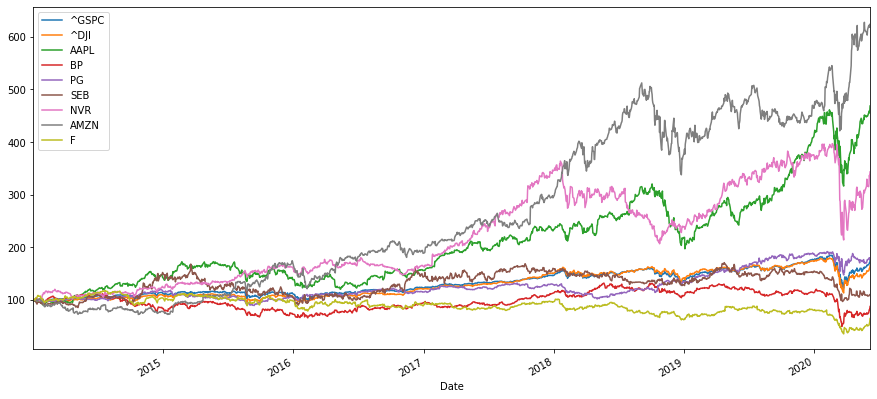

In [5]:
# Add two indices: S&P500 and Dow Jones for comparison
tickers = ['^GSPC', '^DJI'] + tickers
data2 = pd.DataFrame()
#for t in tickers:
#    data2[t] = wb.DataReader(t, data_source='yahoo', start='2014-1-1')['Adj Close'] 
data2 = securities_data(tickers, data2)    
(data2 / data2.iloc[0] * 100).plot(figsize=(15,7))
plt.show()    

Let's pick stocks that are above indeices. (Since the return rate for those stocks would be positive)

In [6]:
tickers2 = ['AMZN','PG','AAPL','NVR']
securities2 = pd.DataFrame()
securities2 = securities_data(tickers2, securities2)

### Let's compare their correlation of returns to mitigate volatility and risk

In [7]:
returns = np.log(securities2 / securities2.shift(1))
# correlation
corr_matrix = returns.corr()
corr_matrix

,AMZN,PG,AAPL,NVR
AMZN,1.000000,0.272787,0.487912,0.227251
PG,0.272787,1.000000,0.418211,0.297395
AAPL,0.487912,0.418211,1.000000,0.353876
NVR,0.227251,0.297395,0.353876,1.000000


We notice that they have low correlation between each pair, therefore we come keep them all.

### Estimate Sharpe Ratio & CAPM

In [8]:
tickers = ['^DJI'] + tickers2
tickers

['^DJI', 'AMZN', 'PG', 'AAPL', 'NVR']

In [9]:
sec = pd.DataFrame()
sec = securities_data(tickers, sec)
# Since comparing mutiple companies at the same time, we use log returns
log_returns = np.log(sec / sec.shift(1))
cov = log_returns.cov() * 250
cov_market = cov.iloc[0,1:]
cov_market

AMZN    0.028173
PG      0.021020
AAPL    0.035363
NVR     0.030073
Name: ^DJI, dtype: float64

In [10]:
# risk_free_rate = 10 yrs Treasury yield 
ticker = ['^TNX']
rf = wb.DataReader(ticker, data_source='yahoo', start='2016-1-1')['Adj Close'].mean()
rf

Symbols
^TNX    2.181682
dtype: float64

In [11]:
var_market = log_returns['^DJI'].var() * 250
beta = cov_market / var_market
beta

AMZN    0.835886
PG      0.623648
AAPL    1.049189
NVR     0.892251
Name: ^DJI, dtype: float64

Since three out of four stocks have beta smaller than one.
Our selected stocks are defensive generally. AAPL is slightly aggressive.


In [12]:
rt = returns.mean() * 250
rt

AMZN    0.283062
PG      0.090605
AAPL    0.238793
NVR     0.190670
dtype: float64

In [13]:
rf = round(rf['^TNX']/100, 3)
rf 

0.022

#### Expected return (CAPM)

In [14]:
# assume premium is 0.05
premium = 0.05
comp = beta.multiply(premium) + rf
comp

AMZN    0.063794
PG      0.053182
AAPL    0.074459
NVR     0.066613
Name: ^DJI, dtype: float64

#### Sharpe ratio

In [15]:
sharpe = (comp - rf) / np.sqrt((log_returns.std() * 250 ))
sharpe

AAPL    0.025194
AMZN    0.019025
NVR     0.020201
PG      0.018121
^DJI         NaN
dtype: float64

## Let's consider 10,000 different combinations of this portfolio

In [16]:
# calculate log rate of return
#securities_returns = (securities2 / securities2.shift(1)) - 1
securities_returns = np.log(securities2 / securities2.shift(1))
securities_returns.head()

,AMZN,PG,AAPL,NVR
Date,,,,
2014-01-02,NaN,NaN,NaN,NaN
2014-01-03,-0.003852,-0.001118,-0.022211,0.002210
2014-01-06,-0.007113,0.002359,0.005438,0.006142
2014-01-07,0.011116,0.009626,-0.007177,-0.011523
2014-01-08,0.009726,-0.014599,0.006313,-0.003933


In [17]:
def ptflio(n):
    pf_returns = []
    pf_vola = []
    pf_sharpe = []
    num_securities = len(securities2.columns)
    save_all_weights = []
    
    for i in range(n):
        # randomly generate weights
        w = np.random.random(num_securities)
        w = w / np.sum(w) # adjusted weights so that the sum of weights is 1
        save_all_weights.append(w)
        
        # portfolio's expected return
        a_yearly_return = 250 * np.sum(w * securities_returns.mean())
        pf_returns.append(a_yearly_return)
        
        # portfolio's expected volatility
        a_vola = np.dot(w.T, np.dot(250 * securities_returns.cov(), w))
        pf_vola.append(np.sqrt(a_vola))
        
        # portfolio's Sharpe ratio
        pf_sharpe.append(a_yearly_return / a_vola)
        
    return pf_returns, pf_vola, pf_sharpe, save_all_weights

In [23]:
# Generate 10,000 number of portfolios
pf_returns, pf_vola, pf_sharpe, pf_w = ptflio(10000)
pflios = pd.DataFrame({'Return': pf_returns, 'Volatility': pf_vola})
pflios.head()

,Return,Volatility
0,0.208893,0.196074
1,0.214833,0.218841
2,0.216212,0.204836
3,0.228036,0.215722
4,0.169465,0.178152


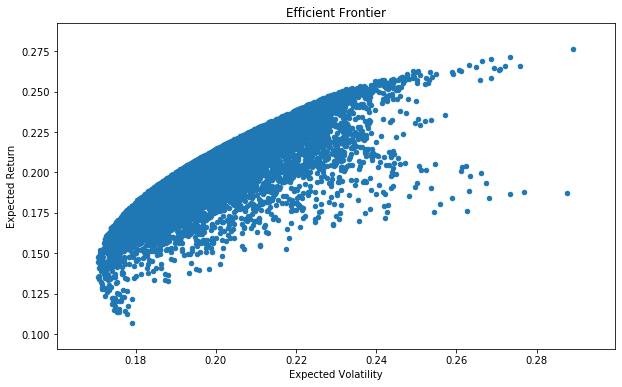

In [24]:
# Markowitz's Efficient Frontier
pflios.plot(x='Volatility', y='Return', kind='scatter', figsize=(10, 6));
plt.title('Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return');

In [25]:
# find portfolio with the highest Sharpe ratio
idx = np.argmax(pf_sharpe)
pf_w[idx]

array([0.2562273 , 0.38407441, 0.18713303, 0.17256526])

In [26]:
# check the return rate and volatility of this portfolio
return_maxSharpe = pf_returns[idx]
vol_maxSharpe = pf_vola[idx]
print(return_maxSharpe)
print(vol_maxSharpe)

0.1849162386821909
0.18147143964912252


Therefore, we should have a portfolio consists:  25.62% of AMZN, 38.41% of PG, 18.71% of AAPL, and 17.26% of MVR.